# Twitter Text Classification

In this post we tackle the problem of classifying tweets to a set of categories. In particular, our goal is to build a model that can classify tweets to different categories such as technology, politics, weather, health, etc. 
Given the large numer of tweets tweeted each day or even each hour, tweet classification can be very useful when our goal is to filter noise and extract information from tweets. For example, in election season, we can filter for tweets that fall in politics category before doing a sentiment analysis on tweets to find which candidates are favored by the population. Or we can extract technology related tweets to find out what is trending in technology. Later in this post, we will obtain tweets that fall in weather category to find out in which parts of the courtry poeple are talking about the weather. 


The two broad approachs that can be used for this problem are supervised and unsupervised learning. In this post we focus on supervised learning. The unsupervised approach focuses on text clustering and topic modeling and we will explore that later in a separate post.

Successful application of supervised learning would require a large enough dataset of labled tweets. We can choose to label the tweets by hand, but that would be a time-consuming and painstaking task. Instead the approach we use here is to collect tweets from well established accounts such as those of new agencies that focus on a particular topic e.g. politics or weather. The drawback of this method is that inevitablly there will be tweets that are miss-labled. For example, a twitter account that tweets about technology may occiationally tweets material about health or politics. This could interfer with our classification and decrease the classification accuracy. We will have to perform a performance evaulation to find out if this approach is paractical.

## Collecting Tweets

To start collecting tweets, in addition to a twitter account, we need to create an [app](http://apps.twitter.com)
associated with the account. Once we register the app, we obtain the credentials necessary to authorize our application to access twitter as if it was the twitter acount itself. Once we have the credentials, we can use python tweepy library to access our twitter account data. The following code sets up tweepy api assuming the app credentials are in 'credentials.csv' file.

In [16]:
import pandas as pd 
credentials = pd.read_csv('credentials.csv')
consumer_key = credentials['consumer_key'][0]
consumer_secret = credentials['consumer_secret'][0]
access_token = credentials['access_token'][0]
access_secret = credentials['access_secret'][0]
 
import tweepy
from tweepy import OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

import warnings
warnings.simplefilter('ignore')

As mentioned before, we are going to follow some well-known twitter accounts to prepare our labeled data. Here are the account we are following:

In [27]:
users = api.friends('<twitter account>', count=100)
[u.screen_name for u in users]

[u'NYTSports',
 u'nytimestech',
 u'BBCPolitics',
 u'BBCSport',
 u'cnnsport',
 u'politico',
 u'CNNPolitics',
 u'HarvardHealth',
 u'NYTHealth',
 u'cnnhealth',
 u'cnntech',
 u'CNET',
 u'rtetwip',
 u'PnPCBC',
 u'NewshubPolitics',
 u'SkyNewsPolitics',
 u'CBSPolitics',
 u'RealClearNews',
 u'foxnewspolitics',
 u'ABCPolitics',
 u'CBCHealth',
 u'CBSHealth',
 u'KHNews',
 u'NBCNewsHealth',
 u'NPRHealth',
 u'bbchealth',
 u'EverydayHealth',
 u'HealthHive',
 u'breakingbytes',
 u'FoxNewsTech',
 u'ReutersTech',
 u'BBCTech',
 u'technology',
 u'TechCrunch',
 u'fttechnews',
 u'NBCNewsTech',
 u'ForbesTech',
 u'TheWeatherNetUS',
 u'bn9weather',
 u'SkyNewsWeather',
 u'HTSportsNews',
 u'NewsdaySports',
 u'FOXSportsNews',
 u'SkySportsNews',
 u'AM730Traffic']

As we can see, we are following 45 account that tweet about technology, politics, health, weather, and sport. Next we set up a timer to priodically collect new tweets from these accounts and save them to a MongoDB database. MongoDB provides data persistance and provides an easy way to manager twitter data. In addition, it accepts json data which is very convenient, since we get the tweets from twitter api as json.

In [29]:
import threading
import time
from pymongo import MongoClient

def collect_tweets(users):
    curr_count = news_tweets.count()
    now = time.time()
    print("Started collecting tweets")
    for user in users:
        try:
            tweets = tweepy.Cursor(api.user_timeline,screen_name=user.screen_name).items()
        except:
            continue
            
        for tw in tweets:
            # See if the tweet already exists in the database
            if news_tweets.find_one({'id':tw.id}):
                break

            try:
                news_tweets.insert_one(tw._json)
            except DuplicateKeyError:
                break
                
    new_count = news_tweets.count()
    new_time = time.time() - now
    print("Collected %d tweets in %.2f seconds" % (new_count - curr_count, new_time))

    

class TimerThread(threading.Thread):
    def __init__(self, interval, task, args=[], kwargs={}):
        super(TimerThread, self).__init__()
        self.stop_ = False
        self.interval = interval
        self.args = args
        self.kwargs = kwargs
        self.task = task
        self.start()
        
    def run(self):
        while not self.stop_:
            self.task(*self.args, **self.kwargs)
            time.sleep(self.interval)
            
    def stop(self):
        self.stop_ = True
client = MongoClient()
news_tweets = client.tweets_db.new_tweets

tthread = TimerThread(15 * 60, collect_tweets, [users])

NameError: global name 'MyThread' is not defined

In the above code:
* We set up a timer thread to wake up every 15 minutes. Once the thread wakes up it goes though the followed accounts and downloads new tweets.

* For each new tweet, we check the database to see we have already collected this tweet. We do this we use the 'id' field which is unique for each tweet.

* Once we see a duplicate tweets for an acount, it means we have collected all new tweets generated by this account in the past 15 minutes. So we move on to the next account.

After running the code for a few hour we have collected arount ... tweets:

In [ ]:
news_tweets.count()

In [104]:
import pandas as pd
tweets_df = pd.DataFrame([[tw['id'], tw['text'], tw['user']['screen_name']] 
                           for tw in news_tweets.find()], columns=['id', 'text', 'user'])


In [106]:
users_df = pd.DataFrame(np.unique(tweets_df_all.user).tolist(), columns=['user'])

cats = [('Traffic', None),
        ('Tech', ['tech', 'breakingbytes', 'CNET']),
        ('Heath', ['health', 'KHNews']),
        ('Sports', 'sport'),
        ('Weather', None),
        ('Politics', ['politic', 'rtetwip', 'realclear', 'PnPCBC']),
       ]
for cat in cats:
    keywords = cat[1]
    cat_name = cat[0]
    if keywords is None:
        keywords = cat_name
    if not isinstance(keywords, list):
        keywords = [keywords]
    print cat
    for index, u in zip(users_df.index, users_df.user):
        for kw in keywords:
            if u.lower().find(kw.lower()) != -1:
                print("\t%s %s"% (u, kw))
                users_df.loc[index, 'cat'] = cat_name
                break

('Traffic', None)
	AM730Traffic Traffic
('Tech', ['tech', 'breakingbytes', 'CNET'])
	BBCTech tech
	CNET CNET
	ForbesTech tech
	FoxNewsTech tech
	NBCNewsTech tech
	ReutersTech tech
	TechCrunch tech
	breakingbytes breakingbytes
	cnntech tech
	fttechnews tech
	nytimestech tech
	technology tech
('Heath', ['health', 'KHNews'])
	CBCHealth health
	CBSHealth health
	EverydayHealth health
	HarvardHealth health
	HealthHive health
	KHNews KHNews
	NBCNewsHealth health
	NPRHealth health
	NYTHealth health
	bbchealth health
	cnnhealth health
('Sports', 'sport')
	BBCSport sport
	FOXSportsNews sport
	HTSportsNews sport
	NYTSports sport
	NewsdaySports sport
	SkySportsNews sport
	cnnsport sport
('Weather', None)
	SkyNewsWeather Weather
	TheWeatherNetUS Weather
	bn9weather Weather
('Politics', ['politic', 'rtetwip', 'realclear', 'PnPCBC'])
	ABCPolitics politic
	BBCPolitics politic
	CBSPolitics politic
	CNNPolitics politic
	NewshubPolitics politic
	PnPCBC PnPCBC
	RealClearNews realclear
	SkyNewsPolitics po

In [108]:
users_df.set_index('user', inplace=True)

In [111]:
tweets_df['cat'] = tweets_df['user'].map(users_df['cat'])

In [112]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

tweets_df['cat_encoded'] = label_encoder.fit_transform(tweets_df.cat)

In [113]:
tweets_df = tweets_df.sample(frac=1)
tweets_df.reset_index(inplace=True, drop=True)
tweets_df.head()

,id,text,user,cat,cat_encoded
0,956561372204208129,Head of UK probe into Russia Brexit meddling a...,fttechnews,Tech,3
1,967204271463849984,Dante Cunningham jokes that he’s one of the ol...,NewsdaySports,Sports,2
2,532113915774504960,US 'won't stand idle' in charging China over c...,breakingbytes,Tech,3
3,962793368001507328,Bollywood film 'Pad Man' aims to shatter taboo...,cnnhealth,Heath,0
4,997582130879217664,Thanks https://t.co/8uPnx735JR,AM730Traffic,Traffic,4


In [114]:
tweets_df['cat'].value_counts()

Heath       35640
Tech        33161
Politics    31675
Sports      23173
Weather      9740
Traffic      3331
Name: cat, dtype: int64

In [116]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        comments_clean = []
        for c in X:
            c = c.replace('\\\\', '\\')
            c = c.replace('\\n', ' ')
            #c = c.replace('\'', '')
            c = re.sub(r'[-_"]', '', c)
            c = re.sub(r'[*%&,?!;]', ' ', c)
            c = re.sub(r"(.)\1{2,}", '\g<1>', c)
            c = re.sub(r'\.(\s+|$)', ' ', c)
            c = re.sub(r'[^\x00-\x7F]+',' ', c)
            #c = re.sub(r'@[^ ]*', ' ', c)
            #c = re.sub(r'[0-9]+', ' ', c)
            c = re.sub(r'https?://[\w./]+', ' ', c)
            c = [wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(w, pos='v')).lower() 
                          for w in c.split()]
            c = " ".join(w for w in c if len(w) > 2)
            #c = " ".join([w.lower() for w in c.split()])# if 3<=len(w)<=40])
            comments_clean.append(c)
        return comments_clean

prep = Preprocessor()

In [117]:
tweets_df['text_processed'] = prep.fit_transform(tweets_df['text'])

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression

tfidf_word_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_char_vectorizer = TfidfVectorizer(ngram_range=(1, 7), analyzer='char', max_df=0.5, max_features=None,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tfidf_word = tfidf_word_vectorizer.fit_transform(tweets_df['text_processed'])
tfidf_char = tfidf_char_vectorizer.fit_transform(tweets_df['text_processed'])

tfidf_word_char = hstack([tfidf_word, tfidf_char])

lr = LogisticRegression()
lr.fit(tfidf_word_char, tweets_df['cat_encoded'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr, tfidf_word_char, tweets_df['cat_encoded'], n_jobs=4)

array([0.93369317, 0.93239418, 0.930131  ])

In [121]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(lr, param_grid={'C': np.logspace(-1, 3, 5)}, return_train_score=True, n_jobs=3)
gs.fit(tfidf_word_char, tweets_df['cat_encoded'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'C': array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [122]:
gs.cv_results_

{'mean_fit_time': array([139.72419206, 194.19813999, 298.00330329, 442.27312509,
        561.86464771]),
 'mean_score_time': array([0.7677803 , 0.94715063, 0.62758541, 0.84880129, 0.47971503]),
 'mean_test_score': array([0.88970889, 0.93207285, 0.94390726, 0.94490199, 0.94490199]),
 'mean_train_score': array([0.90947922, 0.97288984, 0.99743637, 0.99808367, 0.99817876]),
 'param_C': masked_array(data=[0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 1.0}, {'C': 10.0}, {'C': 100.0}, {'C': 1000.0}],
 'rank_test_score': array([5, 4, 3, 1, 1], dtype=int32),
 'split0_test_score': array([0.89125856, 0.93369317, 0.94479551, 0.94488327, 0.9450588 ]),
 'split0_train_score': array([0.90909989, 0.97275739, 0.99733389, 0.99768498, 0.99797024]),
 'split1_test_score': array([0.88958374, 0.93239418, 0.94476993, 0.94615233, 0.94599873]),
 'split1_train_score': array([0.90964047, 0.97

In [123]:
gs.best_params_

{'C': 100.0}

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_word_char, tweets_df['cat_encoded'], test_size=0.33, random_state=42)

In [126]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [127]:
label_encoder.classes_


array(['Heath', 'Politics', 'Sports', 'Tech', 'Traffic', 'Weather'],
      dtype=object)

In [128]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                            target_names=label_encoder.classes_))

             precision    recall  f1-score   support

      Heath       0.93      0.94      0.94     11739
   Politics       0.94      0.94      0.94     10324
     Sports       0.96      0.97      0.96      7681
       Tech       0.93      0.93      0.93     11060
    Traffic       1.00      0.96      0.98      1083
    Weather       0.98      0.94      0.96      3231

avg / total       0.94      0.94      0.94     45118



In [129]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11077   267    68   311     0    16]
 [  282  9709    83   241     0     9]
 [   66    67  7432   106     0    10]
 [  370   290   113 10257     0    30]
 [   12    10    10     4  1041     6]
 [   61    20    24    94     2  3030]]
Normalized confusion matrix
[[9.44e-01 2.27e-02 5.79e-03 2.65e-02 0.00e+00 1.36e-03]
 [2.73e-02 9.40e-01 8.04e-03 2.33e-02 0.00e+00 8.72e-04]
 [8.59e-03 8.72e-03 9.68e-01 1.38e-02 0.00e+00 1.30e-03]
 [3.35e-02 2.62e-02 1.02e-02 9.27e-01 0.00e+00 2.71e-03]
 [1.11e-02 9.23e-03 9.23e-03 3.69e-03 9.61e-01 5.54e-03]
 [1.89e-02 6.19e-03 7.43e-03 2.91e-02 6.19e-04 9.38e-01]]


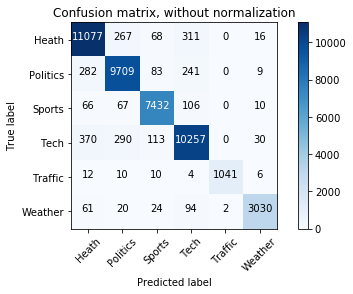

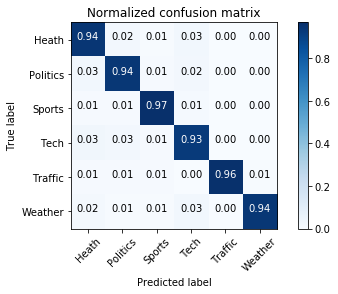

In [130]:
import itertools

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names = label_encoder.classes_

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [ ]:






































a